# Выполнил Лялин Илья Евгеньевич ББМО-02-24



# 1) Скачиваем репозиторий проекта lime_image

In [1]:
!git clone https://github.com/marcotcr/lime.git

fatal: destination path 'lime' already exists and is not an empty directory.


# 2) Устанавливаем lime

In [2]:
!pip install lime

# 3) Установка необходимых библиотек и реалезация датасета MNIST

In [3]:
# для работы с многомерными массивами и математическими операциями
import numpy as np

# для построения графиков и визуализации изображений
import matplotlib.pyplot as plt

# для работы с цветовыми пространствами из библиотеки scikit-image:
# gray2rgb - преобразует изображение в оттенках серого в RGB-формат (добавляя каналы цвета)
# rgb2gray - конвертирует RGB-изображение в оттенки серого (обратная операция)
# label2rgb - преобразует изображение с метками (например, результат сегментации) в цветное RGB-изображение для наглядности
from skimage.color import gray2rgb, rgb2gray, label2rgb

In [4]:
# для загрузки датасетов с платформы OpenML
from sklearn.datasets import fetch_openml


# 'mnist_784' - идентификатор датасета (784 = 28x28 пикселей)
# Датасет содержит изображения рукописных цифр 0-9
mnist = fetch_openml('mnist_784')

# Преобразование данных MNIST в цветной формат для совместимости с LIME Image
X_vec = np.stack([gray2rgb(iimg) for iimg in mnist.data.values.astype(np.uint8).reshape((-1, 28, 28))], 0).astype(np.uint8)
# mnist.data.values - получение данных в виде массива numpy/pandas
# .astype(np.uint8) - преобразование в 8-битный беззнаковый целый тип (0-255)
# .reshape((-1, 28, 28)) - преобразование плоского массива 784px в 2D изображения 28x28
# [gray2rgb(iimg) for iimg in ...] - преобразование каждого ЧБ изображения в RGB формат
# np.stack(..., 0) - объединение всех изображений вдоль оси 0 (создание батча)
# .astype(np.uint8) - финальное приведение типа данных

# Извлечение меток (цифр от 0 до 9) и преобразование в целочисленный тип
y_vec = mnist.target.astype(np.uint8)

# 4) Проверяем работу датасета MNIST, выводим цифру

Text(0.5, 1.0, 'Digit: 5')

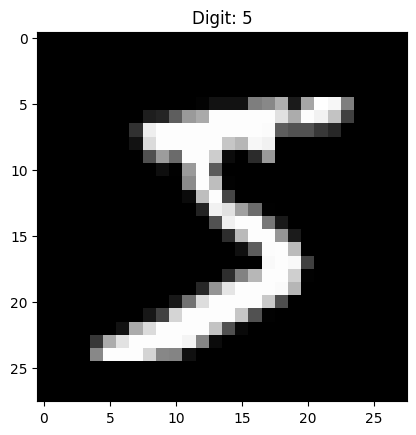

In [5]:
#  для отображения графиков inline
%matplotlib inline

# Создание фигуры и осей для отображения графики:
# plt.subplots(1,1) - создает сетку 1x1 (одно изображение)
# fig - объект всей фигуры, ax1 - объект оси (subplot)
fig, ax1 = plt.subplots(1,1)

# Отображение первого изображения из набора данных X_vec:
# X_vec[0] - первое изображение в массиве (цифра с индексом 0)
# interpolation = 'none' - отключает интерполяцию, показывая пиксели четко без сглаживания
# Это важно для MNIST, так как мы хотим видеть исходные пиксели
ax1.imshow(X_vec[0], interpolation = 'none')

# Установка заголовка для изображения, который показывает какая цифра изображена:
# y_vec[0] - метка (цифра) соответствующая первому изображению
# format(y_vec[0]) подставляет значение метки в строку заголовка
ax1.set_title('Digit: {}'.format(y_vec[0]))

# 5) Установка PIPLINE

In [6]:
# для создания последовательности шагов обработки данных и классификации
from sklearn.pipeline import Pipeline

# алгоритм случайного леса для классификации
from sklearn.ensemble import RandomForestClassifier

# для нормализации данных (закомментирован, но может использоваться)
from sklearn.preprocessing import Normalizer

# Создание кастомного класса-обертки для преобразований в пайплайне
class PipeStep(object):
    """
    Оболочка для преобразования функций в конвейерные преобразования (без подгонки)
    """
    def __init__(self, step_func):
        # Сохранение функции преобразования как атрибута класса
        self._step_func = step_func

    # Метод fit не выполняет обучение, просто возвращает self (т.к. преобразования без обучения)
    def fit(self, *args):
        return self

    # Метод transform применяет сохраненную функцию преобразования к данным
    def transform(self, X):
        return self._step_func(X)


# Создание шага преобразования RGB изображений в оттенки серого
# Использует rgb2gray для каждого изображения в списке
makegray_step = PipeStep(lambda img_list: [rgb2gray(img) for img in img_list])

# Создание шага "выпрямления" (flatten) изображений - преобразование 2D в 1D массив
# ravel() превращает матрицу 28x28 в вектор из 784 элементов
flatten_step = PipeStep(lambda img_list: [img.ravel() for img in img_list])

# Создание пайплайна с последовательностью шагов обработки
simple_rf_pipeline = Pipeline([
    # Первый шаг: преобразование цветных RGB изображений в оттенки серого
    ('Make Gray', makegray_step),

    # Второй шаг: преобразование 2D изображений в 1D векторы
    ('Flatten Image', flatten_step),

    #('Normalize', Normalizer()),  # Нормализация данных
    #('PCA', PCA(16)),             # Уменьшение размерности до 16 компонент

    # Финальный шаг: классификатор случайный лес
    ('RF', RandomForestClassifier())
])

# 6) Создание обучающей и тестовой выборки

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_vec, y_vec,
                                                    train_size=0.55)
# Параметры:
# X_vec - массив с признаками (изображениями)
# y_vec - массив с метками (цифрами)
# train_size=0.55 - 55% данных идет в тренировочную выборку, 45% - в тестовую

# Результат:
# X_train - тренировочные изображения (55% от общего количества)
# X_test - тестовые изображения (45% от общего количества)
# y_train - метки для тренировочных изображений
# y_test - метки для тестовых изображений

Исходный размер: ~70,000 изображений в MNIST

Тренировочная выборка: 55% × 70,000 ≈ 38,500 изображений

Тестовая выборка: 45% × 70,000 ≈ 31,500 изображений

функция автоматически перемешивает данные перед разделением

Стратификация: по умолчанию сохраняет распределение классов в обеих выборках

# 7) Обучение на тестовых данных

In [8]:
simple_rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('Make Gray', <__main__.PipeStep object at 0x7f37af5e3e60>),
                ('Flatten Image', <__main__.PipeStep object at 0x7f37af5b3c50>),
                ('RF', RandomForestClassifier())])




'Make Gray': Каждое RGB изображение в X_train преобразуется в оттенки серого с


помощью rgb2gray

'Flatten Image': Каждое 2D изображение 28×28 "выпрямляется" в 1D вектор из 784 элементов с помощью ravel()

'RF': Обучение классификатора Random Forest на преобразованных данных





Пайплайн принимает исходные RGB изображения размером (n_samples, 28, 28, 3)

После преобразований данные поступают в Random Forest как векторы размером (n_samples, 784)

Random Forest обучается предсказывать цифры (0-9) по этим векторам





Пайплайн сохраняет обученную модель со всеми параметрами

Теперь модель готова для предсказаний на новых данных с помощью simple_rf_pipeline.predict()

# 8) Создание "Объяснялки", то на какие области цифры модель обращает внимание во время предсказания

In [9]:
# LIME используется для объяснения предсказаний моделей машинного обучения
from lime import lime_image

# Эта функция используется для сегментации изображений на суперпиксели
from lime.wrappers.scikit_image import SegmentationAlgorithm

# Создание объясняющего объекта (explainer) для работы с изображениями
# LimeImageExplainer генерирует объяснения для классификации изображений
# verbose=False отключает подробный вывод в процессе работы
explainer = lime_image.LimeImageExplainer(verbose=False)

# Создание алгоритма сегментации для разбиения изображения на значимые области
segmenter = SegmentationAlgorithm('quickshift', kernel_size=1, max_dist=200, ratio=0.2)
# Параметры:
# 'quickshift' - алгоритм сегментации, который группирует пиксели по схожести
# kernel_size=1 - размер ядра для вычисления схожести пикселей
# max_dist=200 - максимальное расстояние между пикселями для объединения в сегмент
# ratio=0.2 - баланс между цветовым и пространственным сходством

LIME создает локальные объяснения: показывает, какие части изображения наиболее важны для предсказания модели

Сегментация разбивает изображение на суперпиксели (однородные области), которые LIME будет "включать/выключать" при генерации объяснений

Quickshift эффективно находит границы объектов на изображении

# 9) Генерация объяснения предсказания модели для конкретного изображения цифры из теста

In [10]:
# покажет время выполнения всего процесса объяснения
%%time

# Генерация объяснения для конкретного тестового изображения
explanation = explainer.explain_instance(
    X_test[0],                          # Первое изображение из тестовой выборки
    classifier_fn = simple_rf_pipeline.predict_proba,  # Функция предсказания вероятностей модели
    top_labels=10,                      # Рассматривать все 10 возможных классов (цифры 0-9)
    hide_color=0,                       # Цвет для "скрытия" сегментов (0 = черный)
    num_samples=10000,                  # Количество сэмплов для генерации (больше → точнее, но медленнее)
    segmentation_fn=segmenter           # Алгоритм сегментации из предыдущего шага
)

  0%|          | 0/10000 [00:00<?, ?it/s]

CPU times: user 7.94 s, sys: 38.2 ms, total: 7.98 s
Wall time: 8.11 s


Берется изображение X_test[0] - первая цифра из тестового набора

Сегментация: изображение разбивается на суперпиксели с помощью quickshift

*Суперпиксели - это группа соседних пикселей, объединенных по схожести характеристик.*


Генерация сэмплов: создается 10,000 модифицированных версий изображения, где случайные сегменты скрываются (закрашиваются черным)

Предсказание: для каждого сэмпла вызывается predict_proba чтобы получить вероятности всех цифр

Обучение объясняющей модели: LIME строит простую модель, которая объясняет, какие сегменты важны для предсказания

Параметры:
num_samples=10000 - большое число для точности (обычно хватает 1000-5000)

hide_color=0 - скрытые области становятся черными

top_labels=10 - анализировать все 10 цифр

# 10) Визуализация результатов LIME-объяснения, показывая какие области изображения влияют на предсказание модели

Text(0.5, 1.0, 'Positive/Negative Regions for 6')

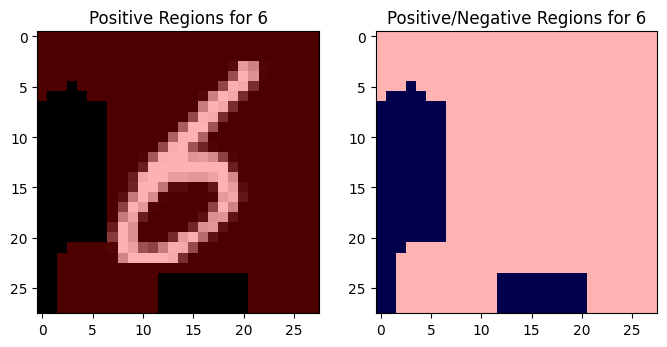

In [11]:
# Получение изображения и маски для визуализации положительных (подтверждающих) регионов
# y_test.iloc[0] - истинная метка первого тестового изображения
# positive_only=True - показывать только области, поддерживающие предсказание
# num_features=10 - ограничить количество показываемых признаков до 10 самых важных
# hide_rest=False - не скрывать остальные части изображения
# min_weight=0.01 - минимальный вес значимости признака для отображения
temp, mask = explanation.get_image_and_mask(y_test.iloc[0], positive_only=True, num_features=10, hide_rest=False, min_weight=0.01)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# Визуализация маски на изображении с помощью цветового кодирования
# label2rgb(mask, temp, bg_label=0) - преобразует маску в цветное наложение на изображение
# interpolation='nearest' - отключает сглаживание для четкого отображения пикселей
ax1.imshow(label2rgb(mask, temp, bg_label=0), interpolation='nearest')

# Установка заголовка для первого subplot с указанием цифры
ax1.set_title('Positive Regions for {}'.format(y_test.iloc[0]))

# Получение изображения и маски для визуализации как положительных, так и отрицательных регионов
# positive_only=False - показывать как поддерживающие, так и противоречащие области
temp, mask = explanation.get_image_and_mask(y_test.iloc[0], positive_only=False, num_features=10, hide_rest=False, min_weight=0.01)

# Визуализация полной маски (положительные и отрицательные регионы)
# 3-mask - инвертирование маски для цветового кодирования (обычно зеленый=положительный, красный=отрицательный)
ax2.imshow(label2rgb(3 - mask, temp, bg_label=0), interpolation='nearest')

# Установка заголовка для второго subplot
ax2.set_title('Positive/Negative Regions for {}'.format(y_test.iloc[0]))

Слева: только важные для распознавания области

Справа: полная картина - что помогает, а что мешает распознаванию

# 11) Сравнение какие области модель ассоциирует с каждой цифрой и какая цифра на самом деле

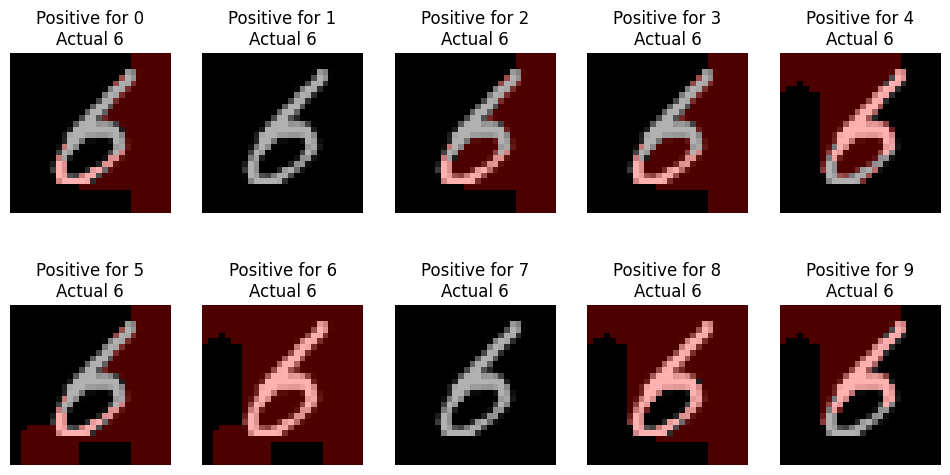

In [12]:
fig, m_axs = plt.subplots(2, 5, figsize=(12, 6))

# Итерация по всем subplots с помощью enumerate
# m_axs.flatten() - преобразует 2D массив осей в 1D для последовательного обхода
# i - номер цифры (от 0 до 9), c_ax - текущая ось для отрисовки
for i, c_ax in enumerate(m_axs.flatten()):

    # Получение изображения и маски для текущей цифры i
    # positive_only=True - показывать только области, поддерживающие цифру i
    # num_features=1000 - включить много признаков (практически все сегменты)
    # min_weight=0.01 - минимальный порог значимости
    temp, mask = explanation.get_image_and_mask(i, positive_only=True, num_features=1000, hide_rest=False, min_weight=0.01)

    # Отображение маски на исходном изображении X_test[0]
    # label2rgb(mask, X_test[0], bg_label=0) - наложение цветной маски на оригинальное изображение
    c_ax.imshow(label2rgb(mask, X_test[0], bg_label=0), interpolation='nearest')

    # Установка заголовка с информацией:
    # i - для какой цифры показаны положительные области
    # y_test.iloc[0] - какая цифра на самом деле
    c_ax.set_title('Positive for {}\nActual {}'.format(i, y_test.iloc[0]))

    # Отключение осей для лучшей визуализации (убирает координатные оси)
    c_ax.axis('off')

# 12) Получаем индекс в котором модель ошиблась, для дальнейшего анализа

In [28]:
# Получение предсказаний пайплайна для всей тестовой выборки
# simple_rf_pipeline.predict(X_test) возвращает массив предсказанных цифр для всех X_test
pipe_pred_test = simple_rf_pipeline.predict(X_test)

# Нахождение случайного индекса ошибочного предсказания:
# np.where(pipe_pred_test != y_test) - находит индексы, где предсказание не совпало с истиной
# [0] - извлекает массив индексов (np.where возвращает кортеж)
# np.random.choice() - случайным образом выбирает один индекс из ошибочных
wrong_idx = np.random.choice(np.where(pipe_pred_test != y_test)[0])

# Вывод информации о выбранной ошибке:
# wrong_idx - индекс ошибочного примера
# y_test[wrong_idx] - истинная метка (какая цифра на самом деле)
# pipe_pred_test[wrong_idx] - что предсказала модель
pipe_pred_test = simple_rf_pipeline.predict(X_test)
wrong_idx = np.random.choice(np.where(pipe_pred_test != y_test.values)[0])

# Используем iloc для доступа по позиции
print('Using #{} where the label was {} and the pipeline predicted {}'.format(
    wrong_idx, y_test.iloc[wrong_idx], pipe_pred_test[wrong_idx]))

Using #1504 where the label was 6 and the pipeline predicted 0


Сначала получаем все предсказания модели на тестовых данных

Находим все случаи, где модель ошиблась (предсказание ≠ истина)

Случайно выбираем одну ошибку для анализа

Выводим информацию об этой ошибке


# 13) Анализируем ошибочный индекс и понимаем, почему она ошиблась

In [29]:
%%time

# Генерация LIME-объяснения для случая, где модель ошиблась
explanation = explainer.explain_instance(
    X_test[wrong_idx],                  # Изображение, на котором модель ошиблась
    classifier_fn = simple_rf_pipeline.predict_proba,  # Функция предсказания вероятностей
    top_labels=10,                      # Анализировать все 10 классов (цифры 0-9)
    hide_color=0,                       # Черный цвет для скрытия сегментов
    num_samples=10000,                  # 10,000 сэмплов для точного объяснения
    segmentation_fn=segmenter           # Алгоритм сегментации на суперпиксели
)

  0%|          | 0/10000 [00:00<?, ?it/s]

CPU times: user 8.19 s, sys: 51.1 ms, total: 8.24 s
Wall time: 8.4 s


# 14) Визуализация LIME-объяснения для ошибочного предсказания модели

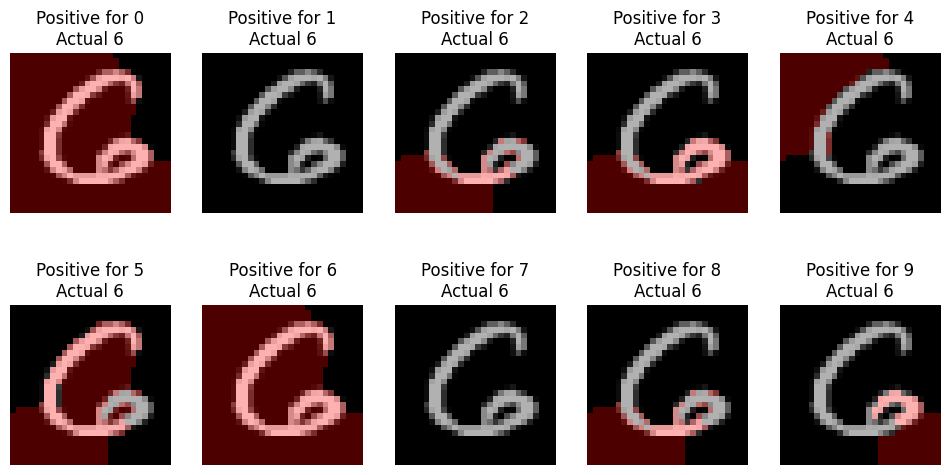

In [30]:
fig, m_axs = plt.subplots(2, 5, figsize=(12, 6))

# Организация цикла по всем subplots с получением индекса и объекта оси
# enumerate(m_axs.flatten()) - преобразует 2D массив осей в 1D и нумерует их (i от 0 до 9)
# i - текущая цифра (0-9), c_ax - текущая ось для отрисовки
for i, c_ax in enumerate(m_axs.flatten()):

    # Получение изображения и маски для текущей цифры i из объяснения
    # i - класс цифры, для которого получаем маску
    # positive_only=True - показывать только области, поддерживающие данную цифру
    # num_features=10 - ограничение до 10 самых важных признаков
    # hide_rest=False - показывать все изображение, а не только выделенные области
    # min_weight=0.01 - минимальный вес значимости для отображения
    temp, mask = explanation.get_image_and_mask(i, positive_only=True, num_features=10, hide_rest=False, min_weight=0.01)

    # Отображение маски на изображении с цветовым кодированием
    # label2rgb(mask, temp, bg_label=0) - наложение цветной маски на изображение
    # interpolation='nearest' - отключение сглаживания для четкого отображения пикселей
    c_ax.imshow(label2rgb(mask, temp, bg_label=0), interpolation='nearest')

    # Установка заголовка для текущего subplot
    # i - цифра, для которой показаны положительные области
    # y_test.iloc[wrong_idx] - истинная метка ошибочного изображения
    c_ax.set_title('Positive for {}\nActual {}'.format(i, y_test.iloc[wrong_idx]))

    # Отключение координатных осей для лучшей визуализации изображения
    c_ax.axis('off')